In [38]:
# Here we will try to predict wether a Magic the Gathering trading card will cost over or under 1$ one the
# open market. We will use the category called "bulk" to signify card under 1$ (bulk == True) and card
# below the cost of 1$ (bulk == False).


# First some data exploration:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
# load the card data
scryData = pd.read_csv('2020_09_25_data_processed/fin_card_data.csv')

In [40]:
# some basic infos
print('Highest price:')
print(scryData['price'].max())
print('Lowest price')
print(scryData['price'].min())
print('Mean price:')
print(scryData['price'].mean())
print('Median price:')
print(scryData['price'].median())
print('Mode price:')
print(scryData['price'].mode())

Highest price:
8066.66
Lowest price
0.01
Mean price:
4.216829122737219
Median price:
0.17
Mode price:
0    0.1
dtype: float64


In [64]:
# This tells us already much about the distrubution of prices. 
# There are a lot of cheap card which only cost about a few ¢ each. 
# But only a few extremely expensive cards exist.
print('Number of all cards:')
print(scryData['price'].shape[0])
print('Number of all cards costing above 4$:')
print(scryData[scryData['price']> 4].shape[0])
print('Number of all cards costing above 10$:')
print(scryData[scryData['price']> 10].shape[0])
print('Number of all cards costing above 20$:')
print(scryData[scryData['price']> 20].shape[0])
print('Number of all cards costing above 100$:')
print(scryData[scryData['price']> 100].shape[0])
print('Number of all cards costing above 1000$:')
print(scryData[scryData['price']> 1000].shape[0])

Number of all cards:
20108
Number of all cards costing above 4$:
1571
Number of all cards costing above 10$:
732
Number of all cards costing above 20$:
363
Number of all cards costing above 100$:
84
Number of all cards costing above 1000$:
14


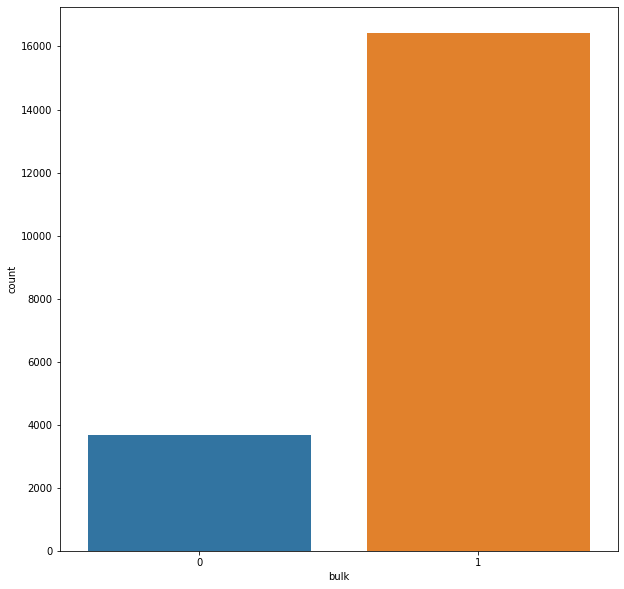

In [43]:
# Lets visualize the data:
# How many so called bulk(below 1$ or bulk == True) and non-bulk(over 1$ or bulk == False) card exist?
sns.countplot(data=scryData, x='bulk')
plt.show()

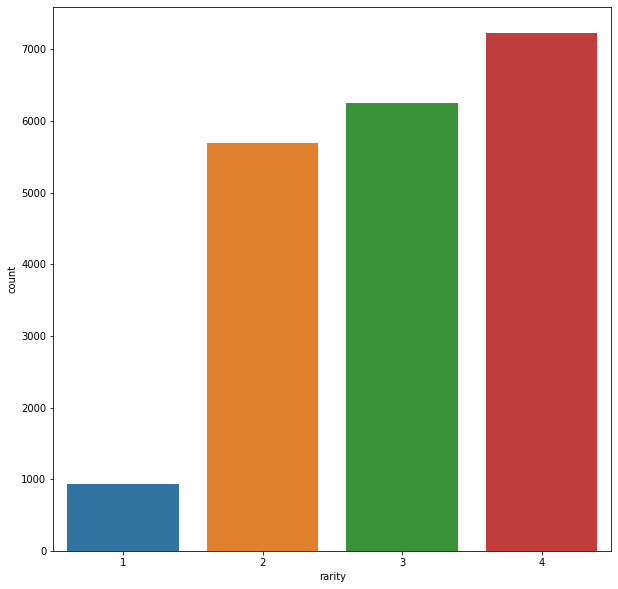

In [44]:
# Magic players know that the main factor of card prize is the so called
# rarity. There are 4 types of rarity (from rarest to most common):
# (1) Mythic, (2) Rare, (3) Uncommon and (4) Common.
# How many cards for each rarity exist?
sns.countplot(data=scryData, x='rarity')
plt.show()

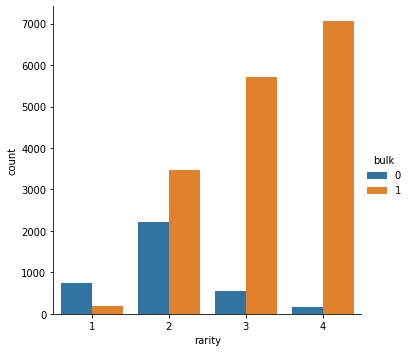

In [65]:
# We can see a that the rarest rarity (Mythic) is exceptionally rare.
# How many card for each rarity are bulk or non-bulk?
sns.catplot(data=scryData, kind='count', x='rarity', hue='bulk')
plt.show()

In [72]:
# The most non-bulk cards are in the rarities of Mythic and Rare but
# there are also some present in the Uncommon and Common rarities.
# So saying that every Mythic or Rare card is non-bulk is not the
# way to go!
# Lets look how all features correlate to bulk:
scryData.corrwith(scryData['bulk'], axis = 0)

is_legendary         -0.291175
is_creature           0.096791
is_instant            0.068483
is_sorcery           -0.003248
is_land              -0.126504
is_enchantment       -0.040416
is_planeswalker      -0.172673
is_artifact          -0.050650
cmc                  -0.060595
first_printing        0.056454
last_printing         0.002627
num_printings        -0.021394
is_id_white           0.001091
is_id_blue           -0.022747
is_id_black          -0.020418
is_id_red             0.032462
is_id_green          -0.024944
is_standard_legal     0.035056
is_commander_legal    0.054452
is_modern_legal       0.110820
is_pioneer_legal      0.112779
is_legacy_legal       0.076288
is_pauper_legal       0.314102
is_reserved          -0.226469
is_reprint           -0.061390
rarity                0.493062
edhrec_rank           0.393925
power                 0.070730
toughness             0.070730
set_enum             -0.070491
is_masters           -0.131322
is_booster            0.052460
oracle_l

In [73]:
# The category "bulk" shows only slight correlation with some
# other variables. Correlation to "price" is obvios,
# because the "bulk" variable is directly obtained from the "price" variable.
# Slight correlation between "bulk" and other variables exist.
# "bulk" shows some correlation to:
# - "edhrec_rank" an online popularity ranking for a specific card on the online platform EDHrec.com
# - "rarity" as expected
# - "is_reserved" (So called reserved cards are prohibited from reprintinted. Only a finite amount 
#   of those cards exists. A lot of those cards are sought after by collectors and players alike.
# - "is_legendary" Legendary cards are a special group of extra special cards.
# - "is_pauper_legal" Pauper is a game where only cards with the rarity common can be used.

In [75]:
# Lets build a classifier.

# import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from xgboost import XGBClassifier

In [76]:
# process the data
bulkData = scryData
y = bulkData['bulk']
bulkData = bulkData.drop(['bulk'], axis=1)
bulkData = bulkData.drop(['name'], axis=1)
bulkData = bulkData.drop(['price'], axis=1)
bulkData = bulkData.drop(['oracle_text'], axis=1)

In [77]:
# define our classifiers
# best hyperparameters were found seperatly by hyperparameter tuning

RF = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1,
                             max_features='sqrt', max_depth=70, bootstrap=False)

SVM = svm.SVC(C=10, gamma=0.0001, kernel='rbf')

xgboost = XGBClassifier(colsample_bytree=1.0, eval_metric='mae', max_depth=5,
        min_child_weight=3, subsample=0.8)

# use a voting classifier
vtc = VotingClassifier(estimators=[('svm', SVM), 
    ('rf', RF), ('xgboost', xgboost)], voting='hard')

In [78]:
# Stratified KFold Scoring
acc = []
rec = []
pre = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(bulkData, y)
for train_index, test_index in skf.split(bulkData, y):
    #print('Train:', train_index, 'Validation:', test_index)
    X1_train, X1_test = bulkData.iloc[train_index], bulkData.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    vtc.fit(X1_train, y1_train)
    prediction = vtc.predict(X1_test)
    acc_score = accuracy_score(prediction, y1_test)
    acc.append(acc_score)
    rec_score = recall_score(prediction, y1_test)
    rec.append(rec_score)
    pre_score = precision_score(prediction, y1_test)
    pre.append(pre_score)

In [80]:
# print the scoring for our model
print('Stratified_KFold mean accuracy:')
print(np.array(acc).mean())
print('')
print('Stratified_KFold mean recall:')
print(np.array(rec).mean())
print('')
print('Stratified_KFold mean precision:')
print(np.array(pre).mean())
print('')

Stratified_KFold mean accuracy:
0.9292324058474412

Stratified_KFold mean recall:
0.9452585771755109

Stratified_KFold mean precision:
0.9695580408672825



In [84]:
X_train, X_test, y_train, y_test = train_test_split(bulkData, y, test_size=0.33)
pred = np.zeros(len(X_test))
print('>>>Naive Classificator all bulk<<<')
print('Accuracy:')
print(accuracy_score(pred, y_test))

pred = np.ones(len(X_test))
print('>>>Naive Classificator all non-bulk<<<')
print('Accuracy:')
print(accuracy_score(pred, y_test))

pred = np.where(X_test['rarity'] == 1, 1, 0)
print('>>>Naive Classificator all Mythic are non-bulk<<<')
print('Accuracy:')
print(accuracy_score(pred, y_test))

pred = np.where(X_test['rarity'] < 3, 1, 0)
print('>>>Naive Classificator all Mythic and Rare are non-bulk<<<')
print('Accuracy:')
print(accuracy_score(pred, y_test))

>>>Naive Classificator all bulk<<<
Accuracy:
0.182790837854129
>>>Naive Classificator all non-bulk<<<
Accuracy:
0.817209162145871
>>>Naive Classificator all Mythic are non-bulk<<<
Accuracy:
0.15687160940325498
>>>Naive Classificator all Mythic and Rare are non-bulk<<<
Accuracy:
0.22076552139843278
